In [45]:
import pandas as pd
import numpy as np
from minisom import MiniSom
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_absolute_percentage_error, r2_score,
                             explained_variance_score, median_absolute_error,
                             max_error)
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    df = df.drop(columns=['Adj Close','Volume'], errors='ignore')
    df.sort_index(inplace=True)
    return df

In [47]:
def create_features(df, lookback=7):
    for i in range(1, lookback+1):
        df[f'Close_Lag_{i}'] = df['Close'].shift(i)
    
    df['MA7'] = df['Close'].rolling(window=7).mean()
    
    df.dropna(inplace=True)
    return df

In [48]:
df = load_data('BBCA.JK_stock_data.csv')
print(df)

                Open      High       Low     Close
Date                                              
2020-01-02 6695.0000 6780.0000 6680.0000 6690.0000
2020-01-03 6750.0000 6800.0000 6725.0000 6800.0000
2020-01-06 6720.0000 6750.0000 6690.0000 6735.0000
2020-01-07 6735.0000 6770.0000 6730.0000 6740.0000
2020-01-08 6670.0000 6745.0000 6670.0000 6680.0000
...              ...       ...       ...       ...
2024-06-24 9600.0000 9750.0000 9575.0000 9600.0000
2024-06-25 9600.0000 9600.0000 9450.0000 9600.0000
2024-06-26 9525.0000 9650.0000 9450.0000 9500.0000
2024-06-27 9575.0000 9750.0000 9550.0000 9750.0000
2024-06-28 9800.0000 9975.0000 9775.0000 9925.0000

[1084 rows x 4 columns]


In [49]:
df = create_features(df, lookback=7)
print(df)

                Open      High       Low     Close  Close_Lag_1  Close_Lag_2  \
Date                                                                           
2020-01-13 6740.0000 6760.0000 6735.0000 6745.0000    6725.0000    6740.0000   
2020-01-14 6745.0000 6885.0000 6740.0000 6870.0000    6745.0000    6725.0000   
2020-01-15 6870.0000 7060.0000 6800.0000 6835.0000    6870.0000    6745.0000   
2020-01-16 6805.0000 6890.0000 6795.0000 6850.0000    6835.0000    6870.0000   
2020-01-17 6840.0000 6890.0000 6800.0000 6875.0000    6850.0000    6835.0000   
...              ...       ...       ...       ...          ...          ...   
2024-06-24 9600.0000 9750.0000 9575.0000 9600.0000    9600.0000    9425.0000   
2024-06-25 9600.0000 9600.0000 9450.0000 9600.0000    9600.0000    9600.0000   
2024-06-26 9525.0000 9650.0000 9450.0000 9500.0000    9600.0000    9600.0000   
2024-06-27 9575.0000 9750.0000 9550.0000 9750.0000    9500.0000    9600.0000   
2024-06-28 9800.0000 9975.0000 9775.0000

In [50]:
max_open = df['Open'].max()
min_open = df['Open'].min()
print(max_open)
print(min_open)

10400.0
4450.0


In [51]:
test_size = 7
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

In [52]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(train.drop(columns=['Close']))
y_train = scaler_y.fit_transform(train[['Close']])
X_test = scaler_x.transform(test.drop(columns=['Close']))
y_test = scaler_y.transform(test[['Close']])

In [53]:
feature_names = train.drop(columns=['Close']).columns.tolist()

train_df = pd.DataFrame(
    X_train,
    columns=feature_names,
    index=train.index
)

test_df = pd.DataFrame(
    X_test,
    columns=feature_names,
    index=test.index
)

full_normalized_df = pd.concat([train_df, test_df])

pd.set_option('display.float_format', '{:.4f}'.format)

print("Normalized Features with Dates:")
print(full_normalized_df)

Normalized Features with Dates:
             Open   High    Low  Close_Lag_1  Close_Lag_2  Close_Lag_3  \
Date                                                                     
2020-01-13 0.3849 0.3500 0.4137       0.3893       0.3919       0.3817   
2020-01-14 0.3857 0.3723 0.4146       0.3927       0.3893       0.3919   
2020-01-15 0.4067 0.4036 0.4249       0.4139       0.3927       0.3893   
2020-01-16 0.3958 0.3732 0.4240       0.4080       0.4139       0.3927   
2020-01-17 0.4017 0.3732 0.4249       0.4105       0.4080       0.4139   
...           ...    ...    ...          ...          ...          ...   
2024-06-24 0.8655 0.8839 0.9013       0.8770       0.8473       0.7837   
2024-06-25 0.8655 0.8571 0.8798       0.8770       0.8770       0.8473   
2024-06-26 0.8529 0.8661 0.8798       0.8770       0.8770       0.8770   
2024-06-27 0.8613 0.8839 0.8970       0.8601       0.8770       0.8770   
2024-06-28 0.8992 0.9241 0.9356       0.9025       0.8601       0.8770   

     

In [54]:
som = MiniSom(5, 5, X_train.shape[1], sigma=1.0, learning_rate=0.7)
som.train(X_train, 1000, verbose=True)

def create_som_features(data, som):
    features = []
    for x in data:
        winner = som.winner(x)
        activation = som.activation_response(np.array([x])).mean()
        features.append([winner[0], winner[1], activation])
    return np.array(features)

X_train_som = create_som_features(X_train, som)
X_test_som = create_som_features(X_test, som)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.09261937768906561


In [55]:
def print_neuron_weights(som, feature_names):
    print("\nSOFM Neuron Weight Vectors:")
    print("=" * 70)
    
    weights = som.get_weights()
    
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            print(f"Neuron ({i},{j}) weights:")
            neuron_weights = weights[i,j]
            
            weight_str = "\n".join([f"- {name}: {weight:.4f}" 
                                   for name, weight in zip(feature_names, neuron_weights)])
            print(weight_str)
            print("-" * 70)

In [56]:
def visualize_sofm_clusters(som, X_train, feature_names):
    """Visualize SOFM clustering results with U-Matrix and Component Planes (2 per row)"""
    # Create 3x2 grid (3 rows, 2 columns)
    plt.figure(figsize=(14, 18))
    
    # 1. U-Matrix (Row 1)
    plt.subplot(3, 2, 1)
    u_matrix = som.distance_map().T
    plt.pcolor(u_matrix, cmap='viridis')
    plt.colorbar()
    plt.title('U-Matrix (Cluster Boundaries)', fontsize=14)
    plt.xlabel('Neuron X')
    plt.ylabel('Neuron Y')
    
    # 2. Component Planes for Key Features
    weights = som.get_weights()
    features_to_plot = ['Open', 'High', 'Low']
    
    # Track subplot position (start from position 2)
    plot_position = 2
    
    for feature in features_to_plot:
        plt.subplot(3, 2, plot_position)
        
        # Find feature index
        feat_idx = feature_names.index(feature) if feature in feature_names else -1
        
        if feat_idx >= 0:
            feature_plane = weights[:, :, feat_idx]
            plt.pcolor(feature_plane.T, cmap='coolwarm')
            plt.colorbar()
            plt.title(f'Component: {feature}', fontsize=12)
            plt.xlabel('Neuron X')
            plt.ylabel('Neuron Y')
        else:
            plt.text(0.5, 0.5, f"{feature} not in features", 
                     ha='center', va='center', fontsize=12)
        
        plot_position += 1  # Move to next subplot position
    
    # Adjust layout
    plt.tight_layout(pad=3.0)
    plt.savefig('sofm_clusters_2_per_row.png', dpi=300, bbox_inches='tight')
    plt.show()

In [57]:
def plot_cluster_assignments(som, X_train, dates):
    plt.figure(figsize=(14, 7))
    
    cluster_ids = []
    for x in X_train:
        winner = som.winner(x)
        cluster_id = winner[0] * som._weights.shape[1] + winner[1]
        cluster_ids.append(cluster_id)
    
    plt.plot(dates, cluster_ids, 'o-', markersize=4)
    
    for cluster in np.unique(cluster_ids):
        cluster_dates = dates[np.array(cluster_ids) == cluster]
        if len(cluster_dates) > 0:
            plt.text(cluster_dates[len(cluster_dates)//2], cluster, 
                     f"C{cluster}", backgroundcolor='yellow', fontsize=8)
    
    plt.title('Cluster Assignments Over Time', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Cluster ID')
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('cluster_timeline.png', dpi=300)
    plt.show()


SOFM Neuron Weight Vectors:
Neuron (0,0) weights:
- Open: 0.2702
- High: 0.2301
- Low: 0.2887
- Close_Lag_1: 0.2731
- Close_Lag_2: 0.2711
- Close_Lag_3: 0.2767
- Close_Lag_4: 0.2799
- Close_Lag_5: 0.2722
- Close_Lag_6: 0.2759
- Close_Lag_7: 0.2810
- MA7: 0.2304
----------------------------------------------------------------------
Neuron (0,1) weights:
- Open: 0.3370
- High: 0.3053
- Low: 0.3548
- Close_Lag_1: 0.3414
- Close_Lag_2: 0.3421
- Close_Lag_3: 0.3406
- Close_Lag_4: 0.3379
- Close_Lag_5: 0.3331
- Close_Lag_6: 0.3328
- Close_Lag_7: 0.3300
- MA7: 0.3013
----------------------------------------------------------------------
Neuron (0,2) weights:
- Open: 0.4900
- High: 0.4744
- Low: 0.5141
- Close_Lag_1: 0.4933
- Close_Lag_2: 0.4899
- Close_Lag_3: 0.4897
- Close_Lag_4: 0.4902
- Close_Lag_5: 0.4931
- Close_Lag_6: 0.4942
- Close_Lag_7: 0.4940
- MA7: 0.4717
----------------------------------------------------------------------
Neuron (0,3) weights:
- Open: 0.6219
- High: 0.6084
- Lo

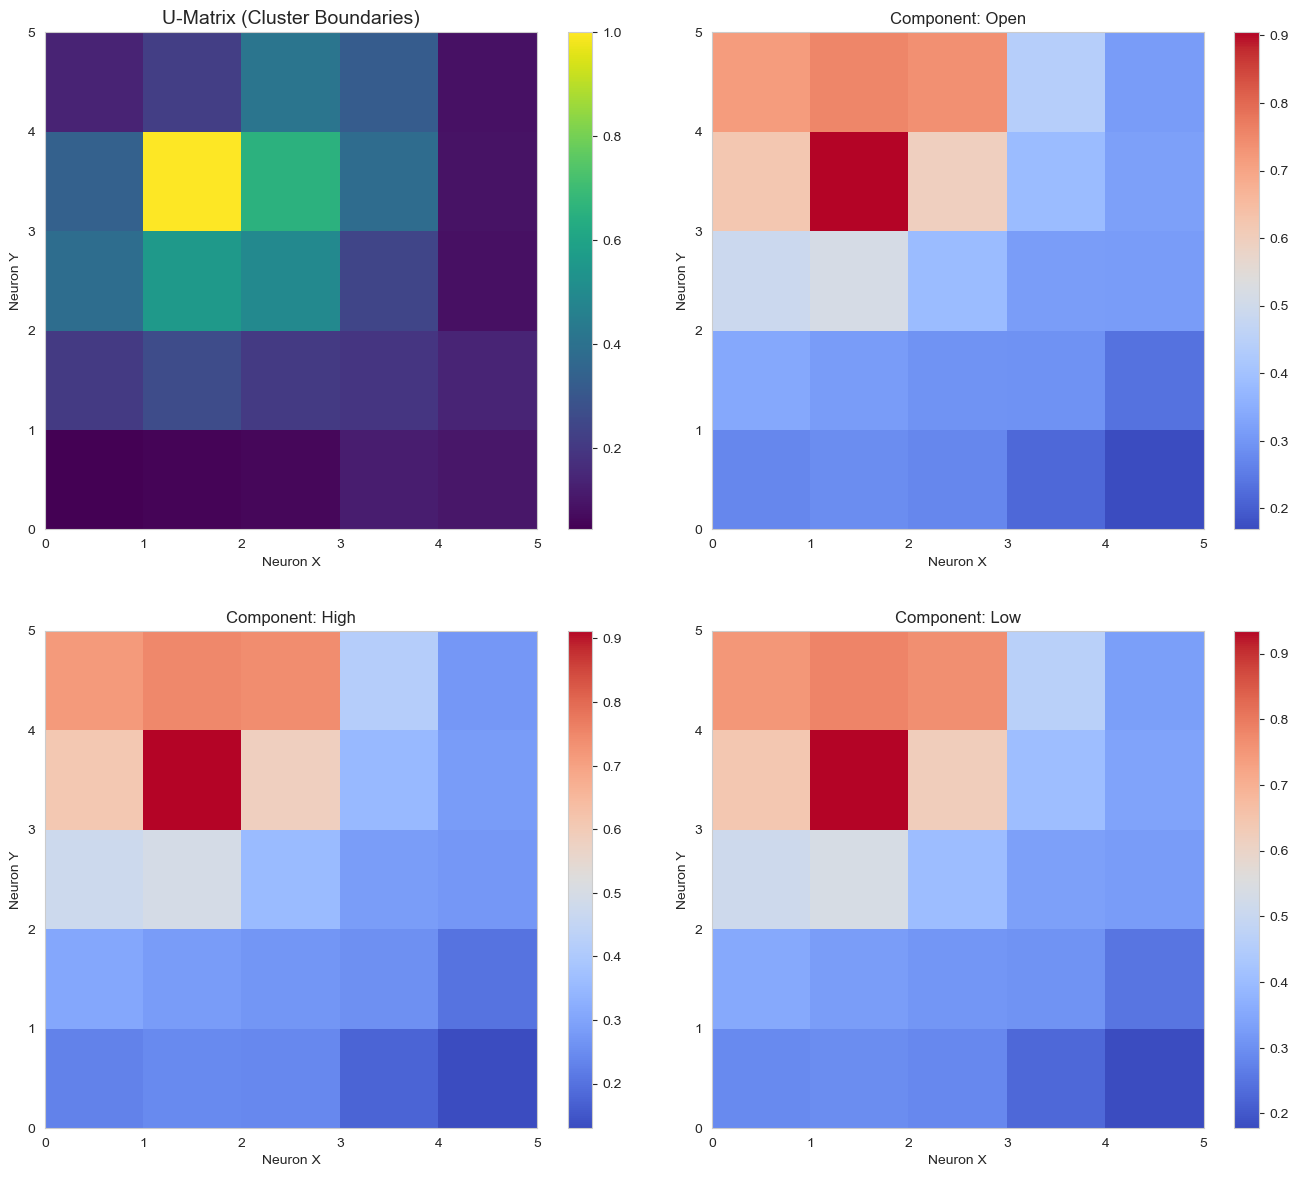

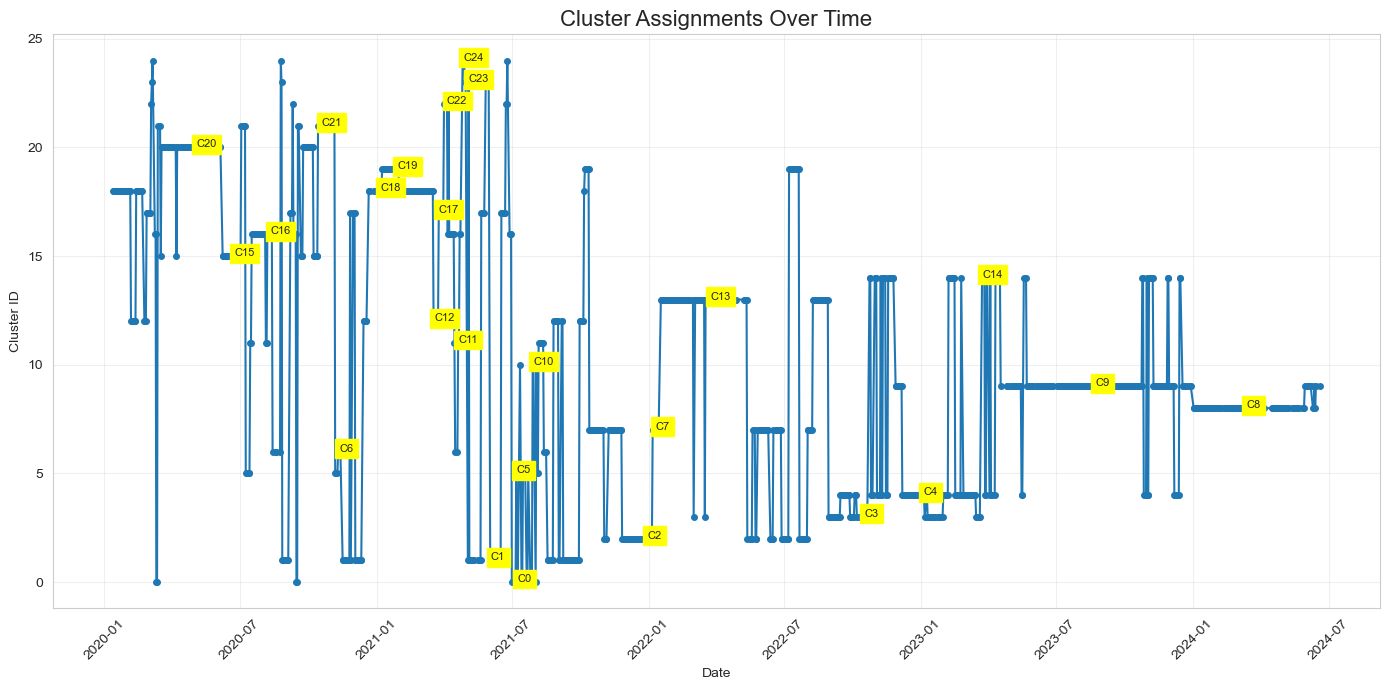

In [58]:
print_neuron_weights(som, feature_names)

visualize_sofm_clusters(som, X_train, feature_names)

plot_cluster_assignments(som, X_train, train.index)

In [59]:
som_feature_names = ['SOFM_X', 'SOFM_Y', 'SOFM_Activation']

som_train=pd.DataFrame(
    X_train_som,
    columns=som_feature_names,
    index=train.index
)

som_test=pd.DataFrame(
    X_test_som,
    columns=som_feature_names,
    index=test.index
)

som_stacked = pd.concat([som_train, som_test])
print(som_stacked)

            SOFM_X  SOFM_Y  SOFM_Activation
Date                                       
2020-01-13  3.0000  3.0000           0.0400
2020-01-14  3.0000  3.0000           0.0400
2020-01-15  3.0000  3.0000           0.0400
2020-01-16  3.0000  3.0000           0.0400
2020-01-17  3.0000  3.0000           0.0400
...            ...     ...              ...
2024-06-24  1.0000  3.0000           0.0400
2024-06-25  1.0000  3.0000           0.0400
2024-06-26  1.0000  3.0000           0.0400
2024-06-27  1.0000  3.0000           0.0400
2024-06-28  1.0000  3.0000           0.0400

[1077 rows x 3 columns]


In [60]:
X_train_full = np.hstack([X_train, X_train_som])
X_test_full = np.hstack([X_test, X_test_som])

In [61]:
feature_names = train.drop(columns=['Close']).columns.tolist()

som_feature_names = ['SOFM_X', 'SOFM_Y', 'SOFM_Activation']

all_feature_names = feature_names + som_feature_names

train_full_df = pd.DataFrame(
    X_train_full,
    columns=all_feature_names,
    index=train.index
)

test_full_df = pd.DataFrame(
    X_test_full,
    columns=all_feature_names,
    index=test.index
)

full_stacked_df = pd.concat([train_full_df, test_full_df])

pd.set_option('display.float_format', '{:.4f}'.format)

print("Stacked Features with Dates:")
print(full_stacked_df)

Stacked Features with Dates:
             Open   High    Low  Close_Lag_1  Close_Lag_2  Close_Lag_3  \
Date                                                                     
2020-01-13 0.3849 0.3500 0.4137       0.3893       0.3919       0.3817   
2020-01-14 0.3857 0.3723 0.4146       0.3927       0.3893       0.3919   
2020-01-15 0.4067 0.4036 0.4249       0.4139       0.3927       0.3893   
2020-01-16 0.3958 0.3732 0.4240       0.4080       0.4139       0.3927   
2020-01-17 0.4017 0.3732 0.4249       0.4105       0.4080       0.4139   
...           ...    ...    ...          ...          ...          ...   
2024-06-24 0.8655 0.8839 0.9013       0.8770       0.8473       0.7837   
2024-06-25 0.8655 0.8571 0.8798       0.8770       0.8770       0.8473   
2024-06-26 0.8529 0.8661 0.8798       0.8770       0.8770       0.8770   
2024-06-27 0.8613 0.8839 0.8970       0.8601       0.8770       0.8770   
2024-06-28 0.8992 0.9241 0.9356       0.9025       0.8601       0.8770   

        

In [62]:
param_grid = {
    'kernel': ['rbf'],
    'C': np.logspace(-2, 4, 20),
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 20)),
    'epsilon': np.linspace(0.001, 0.2, 10)
}

tscv = TimeSeriesSplit(n_splits=5)
svr = SVR()
search = RandomizedSearchCV(svr, param_grid, n_iter=100, cv=tscv,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, verbose=1)
search.fit(X_train_full, y_train.ravel())

best_svr = search.best_estimator_
print(f"Best parameters: {search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kernel': 'rbf', 'gamma': 0.0006158482110660267, 'epsilon': 0.001, 'C': 10000.0}


In [63]:
def evaluate_model(model, X, y, scaler):
    y_pred = model.predict(X)
    y_true = scaler.inverse_transform(y.reshape(-1, 1))
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'R²': r2_score(y_true, y_pred),
        'Explained Variance': explained_variance_score(y_true, y_pred),
        'Median Absolute Error': median_absolute_error(y_true, y_pred),
        'Max Error': max_error(y_true, y_pred)
    }
    return metrics, y_pred

train_metrics, y_train_pred = evaluate_model(best_svr, X_train_full, y_train, scaler_y)
test_metrics, y_test_pred = evaluate_model(best_svr, X_test_full, y_test, scaler_y)

In [64]:
print("\nTraining Metrics:")
print(pd.Series(train_metrics))
print("\nTest Metrics:")
print(pd.Series(test_metrics))


Training Metrics:
MAE                      11.5284
RMSE                     16.8509
MAPE                      0.1590
R²                        0.9998
Explained Variance        0.9998
Median Absolute Error     8.9340
Max Error               207.2434
dtype: float64

Test Metrics:
MAE                     17.6034
RMSE                    21.3729
MAPE                     0.1829
R²                       0.9804
Explained Variance       0.9805
Median Absolute Error   21.3894
Max Error               39.8410
dtype: float64


In [65]:
def recursive_forecast(model, initial_input, steps, som, scaler_x, lookback):
    forecasts = []
    current_input = initial_input.copy()
    
    for _ in range(steps):
        som_features = create_som_features(current_input.reshape(1, -1), som)
        full_input = np.hstack([current_input, som_features])
        
        pred = model.predict(full_input)
        forecasts.append(pred[0])
        
        current_input = np.roll(current_input, -1)
        current_input[-lookback:] = pred[0]
        
    return np.array(forecasts)

In [66]:
initial_input = X_test[-1].reshape(1, -1)
forecast_steps = 7
forecast_scaled = recursive_forecast(best_svr, initial_input, forecast_steps, 
                                    som, scaler_x, lookback=7)
forecast = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1))

In [67]:
forecast_dates = [df.index[-1] + timedelta(days=i) for i in range(1, forecast_steps+1)]

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close': forecast.flatten()
})

last_actual = pd.DataFrame({
    'Date': [df.index[-1]],
    'Forecasted_Close': [df['Close'].iloc[-1]]
})

full_forecast_df = pd.concat([last_actual, forecast_df], ignore_index=True)

full_forecast_df['Daily_Change'] = full_forecast_df['Forecasted_Close'].diff()
full_forecast_df['Pct_Change'] = full_forecast_df['Forecasted_Close'].pct_change() * 100

pd.set_option('display.float_format', '{:.2f}'.format)
print("\nHasil Forecasting 7 Hari ke Depan:")
print(full_forecast_df)


Hasil Forecasting 7 Hari ke Depan:
        Date  Forecasted_Close  Daily_Change  Pct_Change
0 2024-06-28           9925.00           NaN         NaN
1 2024-06-29           9947.59         22.59        0.23
2 2024-06-30           9261.14       -686.45       -6.90
3 2024-07-01           8925.54       -335.60       -3.62
4 2024-07-02           8756.45       -169.09       -1.89
5 2024-07-03           8683.92        -72.52       -0.83
6 2024-07-04           8632.80        -51.12       -0.59
7 2024-07-05           8607.24        -25.57       -0.30


In [68]:
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

<Figure size 1400x700 with 0 Axes>

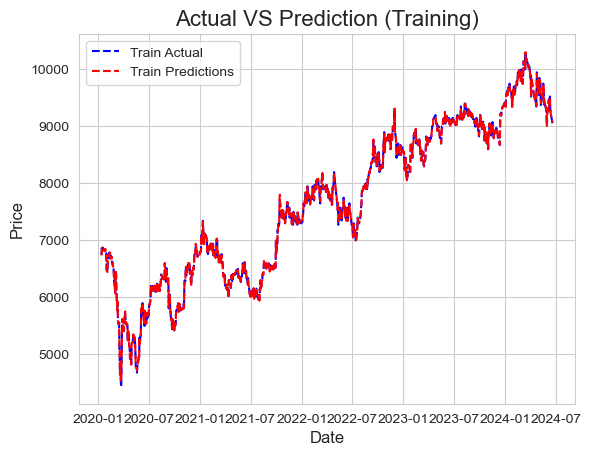

In [69]:
train_dates=train.index
plt.title('Actual VS Prediction (Training)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
line1, = plt.plot(train_dates, train['Close'], label='Train Actual', linestyle='--', color='blue')
line2, = plt.plot(train_dates, y_train_pred, label='Train Predictions', linestyle='--', color='red')
plt.legend(handles=[line1, line2])
plt.show()

In [70]:
target_names = train[['Close']].columns.tolist()

prediction_df = pd.DataFrame(
    y_train_pred,
    columns=target_names,
    index=train.index
)

actual_df = pd.DataFrame(
    train[['Close']],
    columns=target_names,
    index=train.index
)

pd.set_option('display.float_format', '{:.4f}'.format)

actual_vs_prediction_training_df = pd.concat([prediction_df, actual_df], axis=1, keys=['Prediction', 'Actual'])

print("Actual VS Prediction (Training):")
print(actual_vs_prediction_training_df)

Actual VS Prediction (Training):
           Prediction    Actual
                Close     Close
Date                           
2020-01-13  6737.7084 6745.0000
2020-01-14  6864.4208 6870.0000
2020-01-15  6869.1033 6835.0000
2020-01-16  6846.6304 6850.0000
2020-01-17  6862.5701 6875.0000
...               ...       ...
2024-06-11  9318.6067 9300.0000
2024-06-12  9252.5959 9250.0000
2024-06-13  9215.7060 9200.0000
2024-06-14  9184.8627 9200.0000
2024-06-19  9065.4399 9050.0000

[1070 rows x 2 columns]


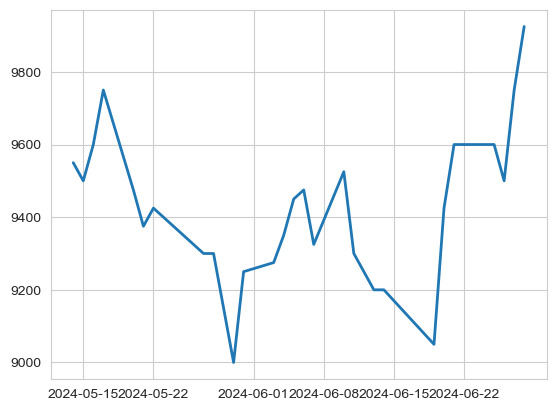

In [71]:
plt.plot(df.index[-30:], df['Close'].values[-30:], label='Historical Prices', linewidth=2)

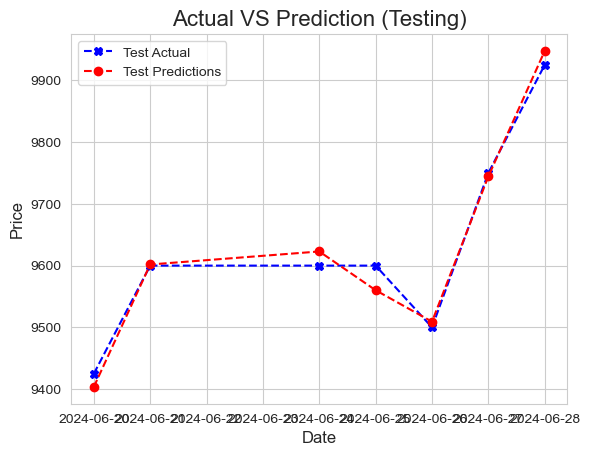

In [72]:
test_dates = test.index
plt.title('Actual VS Prediction (Testing)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
line1, = plt.plot(test_dates, test['Close'], label='Test Actual', marker='X', linestyle='--', color='blue')
line2, = plt.plot(test_dates, y_test_pred, label='Test Predictions', marker='o', linestyle='--', color='red')
plt.legend(handles=[line1, line2])
plt.show()

In [73]:
prediction_testing_df = pd.DataFrame(
    y_test_pred,
    columns=target_names,
    index=test.index
)

actual_testing_df = pd.DataFrame(
    test[['Close']],
    columns=target_names,
    index=test.index
)

pd.set_option('display.float_format', '{:.4f}'.format)

actual_vs_prediction_testing_df = pd.concat([prediction_testing_df, actual_testing_df], axis=1, keys=['Prediction', 'Actual'])

print("Actual VS Prediction (Testing):")
print(actual_vs_prediction_testing_df)

Actual VS Prediction (Testing):
           Prediction    Actual
                Close     Close
Date                           
2024-06-20  9403.6106 9425.0000
2024-06-21  9601.8142 9600.0000
2024-06-24  9622.9020 9600.0000
2024-06-25  9560.1590 9600.0000
2024-06-26  9509.2103 9500.0000
2024-06-27  9744.5196 9750.0000
2024-06-28  9947.5864 9925.0000


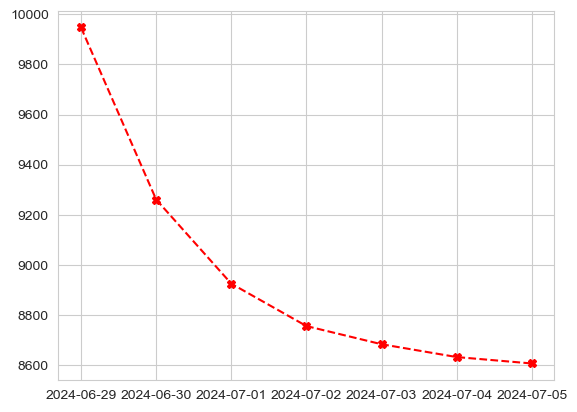

In [74]:
forecast_dates = [df.index[-1] + timedelta(days=i) for i in range(1, forecast_steps+1)]
plt.plot(forecast_dates, forecast, label='7-Day Forecast', marker='X', linestyle='--', color='red')

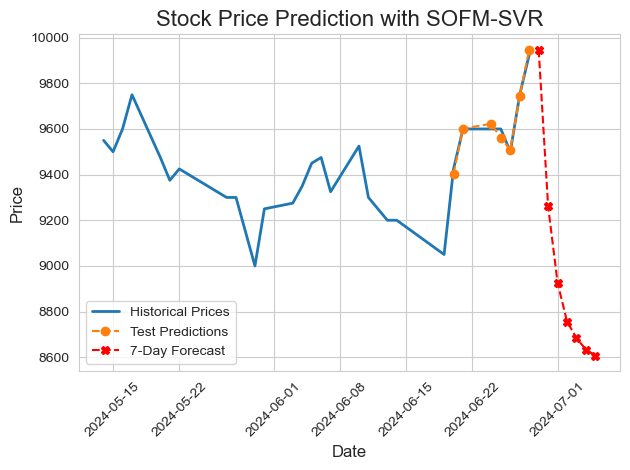

In [75]:
plt.title('Stock Price Prediction with SOFM-SVR', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
line1, = plt.plot(df.index[-30:], df['Close'].values[-30:], label='Historical Prices', linewidth=2)
line2, = plt.plot(test_dates, y_test_pred, label='Test Predictions', marker='o', linestyle='--')
line3, = plt.plot(forecast_dates, forecast, label='7-Day Forecast', marker='X', linestyle='--', color='red')
plt.legend(handles=[line1, line2, line3])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

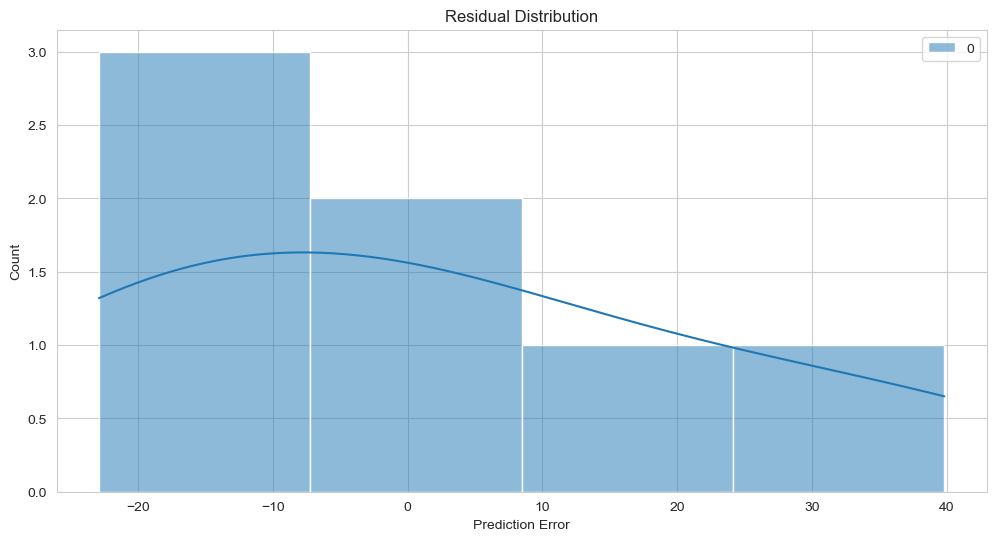

In [76]:
residuals = scaler_y.inverse_transform(y_test) - y_test_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Prediction Error')
plt.show()